<a href="https://colab.research.google.com/github/mpgl/dendrify-paper/blob/main/Fig6-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
> *In this interactive Python notebook, we present and briefly discuss the code needed to replicate the model and the results shown in Figure 6 of the manuscript. In this example our goal is to illustrate that:*
>
> - *Reduced ccompartmental I&F models paired with phenomelogical, event-driven dendritic VGICs can reproduce a broad range of experimental data regarding a specific neuronal type.*
>
> - *Dendrify allows easy access to this category of models by radically simpliying their development in Brian 2.*
>
> **Important:** *here we focus primarily on the code and the results related to Figure 6. The validation protocol used to create the CA1 PC model is partly covered in the Methods section of the manuscript. However, an extensive practical guide will be also available soon on GitHub, as a stand-alone notebook.*
>
> <hr>
>
> *__Note__: In case you are unfamiliar with how Python notebooks work and you would like to run or rerun the entire code, simply select one of the options bellow:*
>
> - **Runtime ➝ Run all**
> - **Runtime ➝ Restart and run all**
>
> *located on the top menu and wait a few seconds until all cells finish running.*
> <hr>
>
> *All source code of the current Dendrify version is available on* [GitHub](https://github.com/mpgl/dendrify-paper)

## Setup

In [1]:
#@title Install dependencies (might take a few seconds)
import os
if 'dendrify' in os.getcwd():
    pass
else:
    !git clone https://github.com/mpgl/dendrify-paper.git --quiet
    os.chdir('dendrify-paper')

!pip install brian2 --quiet

     |████████████████████████████████| 1.5 MB 15.6 MB/s 


In [2]:
#@title Imports and settings
import brian2 as b
from brian2.units import (ms, um, pA, nS, uS, ohm, cm, mV, uF, mvolt, msiemens) # Generally a better practise than * imports
from dendrify import Soma, Dendrite, NeuronModel

b.prefs.codegen.target = 'numpy' # Improves performance significantly here
b.start_scope()    # allows running separate simulations in the same notebook

# @title Figure settings
graphite = "#4B4E53"
blue = '#005c94ff'
green = '#338000ff'
orange = '#ff6600ff'
notred = '#aa0044ff'
dsblue = '#0BA8E6'
light_gray = "#b5b5b5"
params = {
          "legend.fontsize": 10,
          "legend.handlelength": 1.5,
          "legend.edgecolor": 'inherit',
          "legend.columnspacing": 0.8,
          "legend.handletextpad": 0.5,
          "axes.labelsize": 10,
          "axes.titlesize": 11, 
          "axes.spines.right": False,
          "axes.spines.top": False,
          "xtick.labelsize": 10,
          "ytick.labelsize": 10,
          'mathtext.default': 'regular',
          'lines.markersize': 3,
          'lines.linewidth': 1.25,
          'grid.color': "#d3d3d3",
          'grid.linestyle': ":",
          'text.antialiased': True,
          'lines.antialiased': True,
          'figure.dpi': 150,
          'axes.prop_cycle': b.cycler(color=[blue, green, orange, notred])
          }

b.rcParams.update(params)

## Build model

>
><p align="center">
    <img src="https://github.com/mpgl/dendrify-paper/blob/main/graphics/ca1_model.png?raw=true" alt="model" width="50%">
></p>
>

In [3]:
# custom conductance-based adaptive I&F equations and parameters
eqsCAdIF = (
    "dV{0}/dt =  (gL{0}*(EL{0}-V{0}) + Ia{0} + I{0}) / C{0} :volt \n"
    "Ia{0} = gA * (EA-V{0}) :amp \n"
    "dgA/dt = (gAmax * (abs(V{0}-VA)) / mV - gA) / tauA :siemens \n"
    "I{0} = I_ext{0}  :amp \n"
    "I_ext{0}  :amp")

paramsCAdIF = {
    "EA": -65 * mV,  # reversal potential of Ia
    "VA": -65 * mV,  # subthreshold adaptation activation voltage
    "tauA": 45 * ms,  # time constant of adaptation
    "gAmax": 0.15 * nS,  # maximal subthreshold adaptation conductance
    "delta_gA": 21*nS,  # spike-triggered adaptation
    "Vth": -47.5 * mV,  # AP threshold -47.5
    "Vr1": 37.5 * mV}  # 1st voltage seset after AP

# set basic parameters using values from experimental data
paramsExp = {
    'alpha': 0.087,
    'beta':  3.57,
    'gamma': 10,
    'Mg': 1,
    'E_NMDA': 0.35*mV,
    "E_Na": 50 * mV,
    "E_K": -90 * mV,}

gNa = 10*msiemens*cm**-2
gKn = gNa/2.5
Vdspike = -42.5*mV

# create soma
soma = Soma('soma', model=eqsCAdIF, length=30*um, diameter=20*um)

# create the proximal apical dendrite
proximal = Dendrite('prox', length=100*um, diameter=2*um)
proximal.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*proximal.area,
                  g_fall=gKn*proximal.area)

# create the 1st oblique dendrite
oblique_1 = Dendrite('ob1', length=100*um, diameter=1*um)
oblique_1.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*oblique_1.area,
                  g_fall=gKn*oblique_1.area)

# create the 2nd oblique dendrite
oblique_2 = Dendrite('ob2', length=100*um, diameter=1*um )
oblique_2.dspikes('Na', threshold=Vdspike,
                  g_rise=gNa*oblique_2.area,
                  g_fall=gKn*oblique_2.area)

# create the medial apical dendrite
medial = Dendrite('med', length=150*um, diameter=1.25*um)
medial.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*medial.area,
                g_fall=gKn*medial.area)

# create the 1st distal apical dendrite
distal_1 = Dendrite('dist1', length=150*um, diameter=0.8*um )
distal_1.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*distal_1.area,
                g_fall=gKn*distal_1.area)

# create the 2nd distal apical dendrite
distal_2 = Dendrite('dist2', length=150*um, diameter=0.8*um)
distal_2.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*distal_1.area,
                g_fall=gKn*distal_1.area)

# create the 1st basal dendrite
basal_1 = Dendrite('bas1', length=150*um, diameter=0.8*um)
basal_1.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*basal_1.area,
                g_fall=gKn*basal_1.area)

# create the 2nd basal dendrite
basal_2 = Dendrite('bas2', length=150*um, diameter=0.8*um)
basal_2.dspikes('Na', threshold=Vdspike,
                g_rise=gNa*basal_2.area,
                g_fall=gKn*basal_2.area)

edges = [(soma, basal_1, 3.8*nS), (soma, basal_2, 3.8*nS),
         (soma, proximal, 22*nS), (proximal, oblique_1),
         (proximal, oblique_2), (proximal, medial), 
         (medial, distal_1), (medial, distal_2)]

# add synapses
oblique_1.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
oblique_1.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
oblique_2.synapse("AMPA", pre='ca3', g=0.6*nS, t_decay=2.5*ms)
oblique_2.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
medial.synapse("AMPA", pre='ca3', g=0.81*nS, t_decay=2.5*ms)
medial.synapse("NMDA", pre='ca3', g=0.4*nS, t_decay=50*ms)
distal_1.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
distal_1.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
distal_2.synapse("AMPA", pre='ec', g=0.81*nS, t_decay=2.5*ms)
distal_2.synapse("NMDA", pre='ec', g=0.81*nS, t_decay=50*ms)
proximal.synapse("AMPA", pre='validation', g=0.6*nS, t_decay=2.5*ms)  # will be used only for validation purposes later
proximal.synapse("NMDA", pre='validation', g=0.4*nS, t_decay=50*ms)   # will be used only for validation purposes later

# merge all compartments into a single model
pyr_model = NeuronModel(edges, cm=1*uF/(cm**2), gl=40*uS/(cm**2),
                        r_axial=120*ohm*cm, v_rest=-65*mV,
                        scale_factor=2.9, spine_factor=1.5)

# include model params
pyr_model.add_params(paramsCAdIF)
pyr_model.add_params(paramsExp)
pyr_model.dspike_properties('Na', tau_rise=0.5*ms, tau_fall=1.2*ms,
                            refractory=4.2*ms, offset_fall=0.6*ms)

> ***Note 1:*** *the above syntax for adding dSpikes will be significantly simpler in future dendrify versions. It will allow users to enter the desired values for gNa and gK (lines 28, 29) and dendrify will automatically multiply them by each compartment's surface area (eg. lines 38, 39 will not be necessary).*
>
><br>
>
> ***Note 2:*** *as shown here, dendrify users can include their own equations using strings that can be formatted to have compartment-specific variable names (eg. "V{0}" will become "V_soma").*

## Inspect model

### Model graph
> *To get a graph-like representation of the model, call the method bellow.
**WARNING**: this method utilises the spring algorithm found in networkx and its output may vary every time you call it. For reproducibility you can specify a seed of your choice. Edges' length does not represent any specific property.*

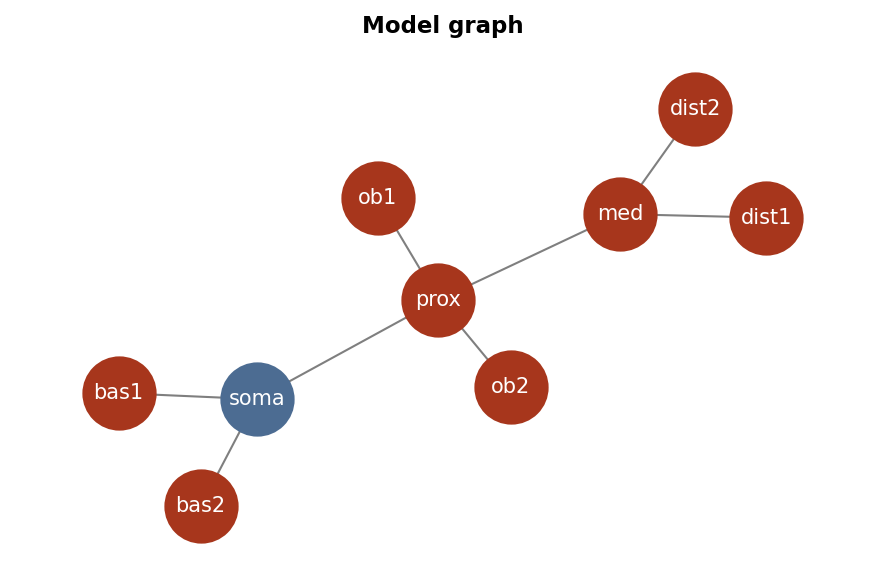

In [4]:
pyr_model.as_graph(seed=1234)

### Equations, parameters & events

In [5]:
print(pyr_model)

OBJECT TYPE:

  <class 'dendrify.neuronmodel.NeuronModel'>

---------------------------------------------

PROPERTIES (type): 

→ equations (str):
    dV_soma/dt =  (gL_soma*(EL_soma-V_soma) + Ia_soma + I_soma) / C_soma :volt 
    Ia_soma = gA * (EA-V_soma) :amp 
    dgA/dt = (gAmax * (abs(V_soma-VA)) / mV - gA) / tauA :siemens 
    I_soma = I_ext_soma + I_prox_soma  + I_bas2_soma  + I_bas1_soma   :amp 
    I_ext_soma  :amp
    I_bas1_soma = (V_bas1-V_soma) * g_bas1_soma  :amp
    I_bas2_soma = (V_bas2-V_soma) * g_bas2_soma  :amp
    I_prox_soma = (V_prox-V_soma) * g_prox_soma  :amp
    
    dV_bas1/dt = (gL_bas1 * (EL_bas1-V_bas1) + I_bas1) / C_bas1  :volt
    I_bas1 = I_ext_bas1 + I_soma_bas1  + I_Na_bas1 + I_Kn_bas1  :amp
    I_ext_bas1  :amp
    I_Na_bas1 = g_Na_bas1 * (E_Na-V_bas1)  :amp
    I_Kn_bas1 = g_Kn_bas1 * (E_K-V_bas1)  :amp
    dg_Na_bas1/dt = -g_Na_bas1/tau_Na  :siemens
    dg_Kn_bas1/dt = -g_Kn_bas1/tau_Kn  :siemens
    allow_I_Na_bas1  :boolean
    allow_I_Kn_bas1  :b

## Create a NeuronGroup

In [6]:
pyr_group = b.NeuronGroup(8, threshold='V_soma > Vth', refractory=4*ms,
                          reset='V_soma = Vr1; gA += delta_gA', method='euler',
                          model=pyr_model.equations, events=pyr_model.events,
                          namespace=pyr_model.parameters)
    
# link pyramidal model to the neurongroup
pyr_model.link(pyr_group)

# second reset trick
second_reset = b.Synapses(pyr_group, pyr_group,
                          on_pre='V_soma=-53 * mV', delay=0.8*ms)
second_reset.connect(j='i')

## Panels b-d, f

In [7]:
# set monitors to record membrane voltages
vars = ["V_soma", "V_prox", "V_med", "V_dist1"]
M = b.StateMonitor(pyr_group, vars, record=True)
S = b.SpikeMonitor(pyr_group)

# select currents
currents = [-350, -10, 100, 150, 200, 250, 300, 350]

# first 50 ms -> no input
b.run(50*ms)

# next 1000 ms -> current injection
for neuron, I in enumerate(currents):
    pyr_group.I_ext_soma[neuron] = I * pA
b.run(1000*ms)

# next 100 ms -> no input
for neuron in range(len(currents)):
    pyr_group.I_ext_soma[neuron] = 0 * pA
b.run(100*ms)

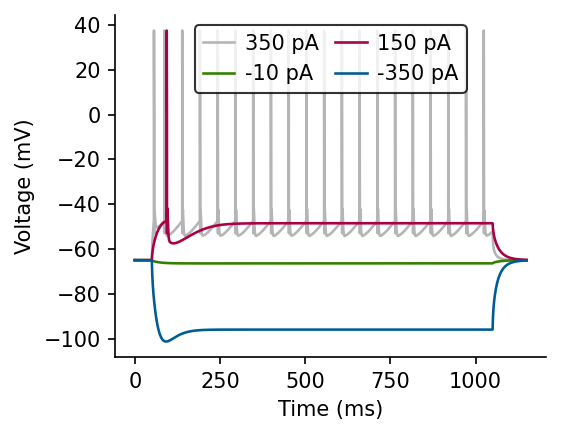

In [8]:
# @title Plot traces
time = M.t/ms
vs = M.V_soma/mV
vp = M.V_prox/mV
vm = M.V_med/mV
vd = M.V_dist1/mV

fig, ax = b.subplots(figsize=[4,3])
voltages = [vs[7], vs[1], vs[3], vs[0]]
colors = [light_gray, green, notred, blue]
labels = ['350', '-10', '150', '-350']

for trace, c, l in zip(voltages, colors, labels):
    ax.plot(time, trace, c=c, label=f'{l} pA')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.legend(ncol=2, loc='upper center')
fig.tight_layout()

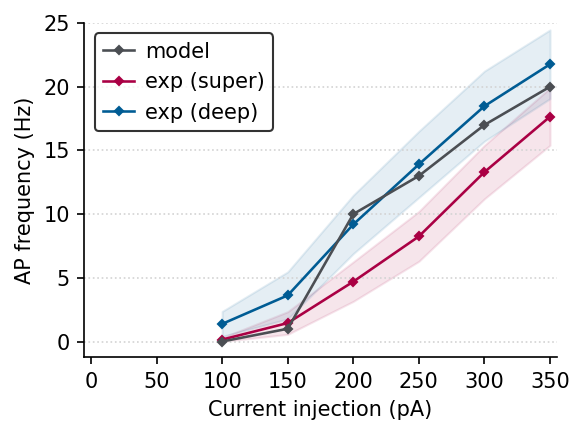

In [9]:
# @title Plot F-I curve
currents = range(100, 400, 50)
spikes = S.count[2:]

# experimental data from Masurkar et al:
exp_superficial = b.array([0.15, 1.45, 4.7, 8.25, 13.3, 17.65])
sem_superficial = b.array([0.15, 0.889929033, 1.549363, 1.955929, 2.097743, 2.250468])
exp_deep = b.array([1.380952381, 3.619047619, 9.190476, 13.90476, 18.47619, 21.7619])
sem_deep = b.array([0.979494988, 1.847103512, 2.293489, 2.598447, 2.751293, 2.699122])

fig, ax = b.subplots(figsize=[4,3])
ax.plot(currents, spikes,'D-', c=graphite, label='model', zorder=3)

ax.plot(currents, exp_superficial, marker='D', ls='-', label='exp (super)', c=notred)
ax.fill_between(currents, y1=exp_superficial+sem_superficial,
                 y2=exp_superficial-sem_superficial, alpha=0.1,
                 color=notred, ec='none')

ax.plot(currents, exp_deep, marker='D', ls='-', label='exp (deep)', color=blue)
ax.fill_between(currents, y1=exp_deep+sem_deep,
                 y2=exp_deep-sem_deep, alpha=0.1,
                 color=blue, ec='none')


ax.set_xlabel("Current injection (pA)")
ax.set_ylabel("AP frequency (Hz)")
ax.set_xlim(left=-5, right=355)
ax.set_ylim(top=25)
ax.set_xticks(range(0, 400, 50))
ax.legend()
ax.yaxis.grid(zorder=0)
ax.set_yticks(range(0, 30, 5))
fig.tight_layout()



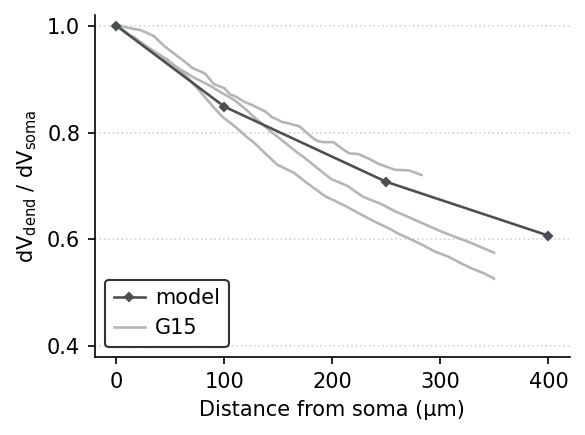

In [10]:
# @title Plot steady state attenuation
# experimental data from golding et al:
with open('other/Cell_1.csv') as c1, \
     open('other/Cell_2.csv') as c2, \
     open('other/Cell_3.csv') as c3:

    cell_1 = b.loadtxt(c1, delimiter=',')
    cell_2 = b.loadtxt(c2, delimiter=',')
    cell_3 = b.loadtxt(c3, delimiter=',')

# analyse model data:
dv = abs(b.array([vs[1], vp[1], vm[1], vd[1]]).min(axis=1) + 65)
dv_dvsoma = dv / dv[0]

fig, ax = b.subplots(figsize=[4,3])
ax.plot([0, 100, 250, 400], dv_dvsoma, 'D-', label='model', c=graphite, zorder=3)
ax.plot(b.sort(cell_1[:,0]), -b.sort(-cell_1[:,1]), c=light_gray, label='G15')
ax.plot(b.sort(cell_2[:,0]), -b.sort(-cell_2[:,1]), c=light_gray)
ax.plot(b.sort(cell_3[:,0]), -b.sort(-cell_3[:,1]), c=light_gray)
ax.legend(loc='lower left')
ax.set_ylim(bottom=.38, top=1.02)
ax.set_ylabel(r'$dV_{dend}$ / $dV_{soma}$')
ax.set_xlabel('Distance from soma (μm)')
ax.set_yticks(b.arange(.4, 1.2, .2))
ax.yaxis.grid(zorder=0)
fig.tight_layout()

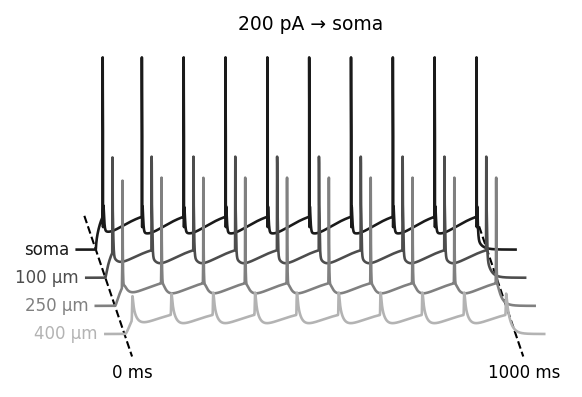

In [11]:
# @title Plot AP backpropagation
def line1(xlist):
    y = []
    for x in xlist:
        _y = -0.6 * x -35
        y.append(_y)
    return y

x1 = b.arange(20, 146)
y1 = line1(x1)
x2 = x1+1025

fig, ax = b.subplots(figsize=[4,2.75])
names = ['soma', '100 μm', '250 μm', '400 μm']
traces = [vs[4], vp[4], vm[4], vd[4]]
colors = ['#1a1a1a', '#4d4d4d', '#808080', '#b3b3b3']

t_shift = 0
v_shift = 0
hpad=-20
for v, name, col in zip(traces, names, colors):
    ax.plot(time+t_shift, v+v_shift, c=col)
    ax.text(time[0]+hpad+t_shift, v[0]+v_shift, name,
            fontsize=8, ha='right', va='center', c=col)
    v_shift -= 15
    t_shift += 25

ax.plot(x1, y1, ls='--', c='black', zorder=0, lw=1)
ax.plot(x2, y1, ls='--', c='black', zorder=0, lw=1)
ax.text(x1[-1]+2, y1[-1]-4, '0 ms', ha='center', va='top', fontsize=8)
ax.text(x2[-1]+2, y1[-1]-4, '1000 ms', ha='center', va='top', fontsize=8)
ax.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title("200 pA \u2192 soma", fontsize=9)
fig.tight_layout()

## Panels e, g-h
> *In the followning experiments instead of using current injections, we will apply synaptic inputs to estimate various important model properties.*

In [12]:
# create a new Brian NeuronGroup and link it to the existing NeuronModel
b.start_scope()    # allows running separate simulations in the same notebook
pyr_group = b.NeuronGroup(3, threshold='V_soma > Vth', refractory=4*ms,
                          reset='V_soma = Vr1; gA += delta_gA', method='euler',
                          model=pyr_model.equations, events=pyr_model.events,
                          namespace=pyr_model.parameters)
    
# link pyramidal model to the neurongroup
pyr_model.link(pyr_group)

# second reset trick
second_reset = b.Synapses(pyr_group, pyr_group,
                          on_pre='V_soma=-53 * mV', delay=0.8*ms)
second_reset.connect(j='i')

# set voltage monitors
variables = ('V_soma', 'V_prox', 'V_med', 'V_dist1', 'V_ob1' )
M = b.StateMonitor(pyr_group, variables, record=True)

# synaptic input protocol
Input = b.SpikeGeneratorGroup(1, [0], [10*ms])

S100 = b.Synapses(
    Input, pyr_group,
    on_pre="s_AMPA_validation_prox += 1.0; s_NMDA_validation_prox += 1.0")
S100.connect(j='0')
    
S250 = b.Synapses(
    Input, pyr_group,
    on_pre="s_AMPA_ca3_med += 1.0; s_NMDA_ca3_med += 1.0")
S250.connect(j='1')
    
S400 = b.Synapses(
    Input, pyr_group,
    on_pre="s_AMPA_ec_dist1 += 1.0; s_NMDA_ec_dist1 += 1.0")
S400.connect(j='2')

# run simulation
b.run(100*ms)

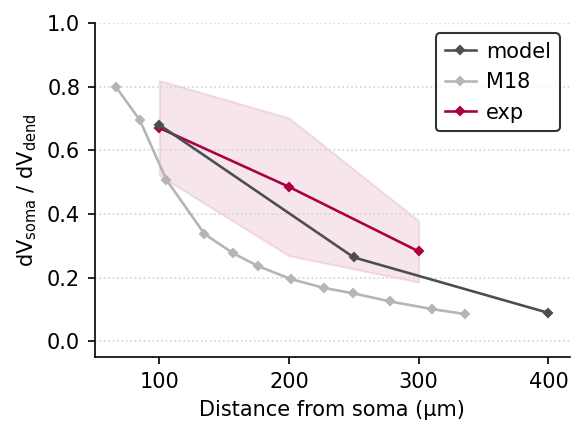

In [13]:
# @title Plot synaptic attenuation
time = M.t/ms
vs = M.V_soma/mV
vp = M.V_prox/mV
vm = M.V_med/mV
vd = M.V_dist1/mV

# load experimental (Magee) and biophysical modeling (Migliore) data
# the json file is form Tomko et al
import json
data_psp = json.load(open('other/PSP_attenuation_all.json'))
mig_x = b.sort([i['distance'] for i in data_psp['M18'].values()])
mig_y = b.sort([-i['attenuation_soma/dendrite'] for i in data_psp['M18'].values()])
exp_x = [i['distance'] for i in data_psp['exp'].values()]
exp_y = [i['attenuation_soma/dendrite'] for i in data_psp['exp'].values()]
exp_err = [i['attenuation_soma/dendrite_std'] for i in data_psp['exp'].values()]

# process simulation data
dv_dend = b.array([vp[0], vm[1], vd[2]]).max(axis=1) + 65
dv_soma = b.array([vs[0], vs[1], vs[2]]).max(axis=1) + 65

fig, ax = b.subplots(figsize=[4,3])

ax.plot([100, 250, 400], dv_soma/dv_dend, 'D-', c=graphite,
         label='model' , zorder=4)

ax.plot(mig_x, -mig_y, 'D-', label='M18', c=light_gray, zorder=3 )
ax.plot(exp_x, exp_y, 'D-', label='exp', zorder=3, c=notred, )
ax.fill_between(exp_x, y1=b.array(exp_y)+b.array(exp_err)*2,
                  y2=b.array(exp_y)-b.array(exp_err)*2, alpha=0.1,
                  color=notred, ec='none')
ax.legend(ncol=1)
ax.set_ylim(bottom=-0.05, top=1)
ax.set_ylabel(r'$dV_{soma}$ / $dV_{dend}$')
ax.set_xlabel('Distance from soma (μm)')
ax.yaxis.grid(zorder=0)
fig.tight_layout()